## ipyparallel
http://ipyparallel.readthedocs.io/en/latest/intro.htm

In [1]:
# Install ipyparallel
# pip install ipyparallel

# Start a cluster in console mode.
# ipcluster start -n 4

# To enable the IPython Clusters tab in Jupyter Notebook, same as "ipcluster start".
# ipcluster nbextension enable

In [2]:
from ipyparallel import Client
rc = Client()

rc.ids

[0, 1, 2, 3]

In [3]:
#%px sum(range(101))

In [4]:
def mygetpid():
    import os
    return os.getpid()

In [5]:
mygetpid()

7896

In [6]:
rc[0].apply_sync(mygetpid)

1108

In [7]:
rc[1].apply_sync(mygetpid)

4952

In [8]:
rc[2].apply_sync(mygetpid)

1304

In [9]:
rc[3].apply_sync(mygetpid)

9856

In [10]:
ar = rc[:].apply_async(mygetpid)
pid_map = ar.get_dict()

In [11]:
print(pid_map)

{0: 1108, 1: 4952, 2: 1304, 3: 9856}


### Parallel map

In [12]:
with rc[:].sync_imports():
    import numpy

dview = rc[:] # use all engines

importing numpy on engine(s)


In [13]:
serial_result = map(lambda x:x**10, range(32))

parallel_result = dview.map_sync(lambda x: x**10, range(32))

serial_result==parallel_result

False

In [14]:
# map() is not always better than iterative calls!
# ipyparallel is not always bettwer than map()!]
# Try to change 'power' to 521
# Try to change 'my_range' to 10000

import timeit

my_range = 1024
my_number = 32

def costly_func1():
    global my_range
    map(lambda x: x**128, range(my_range)) # try list() this map

def costly_func2():
    global dview, my_range
    dview.map_async(lambda x: x**128, range(my_range))
    
def costly_func3():
    global dview, my_range
    dview.map_sync(lambda x: x**128, range(my_range))
    

print(timeit.timeit(costly_func1, number = my_number))
print(timeit.timeit(costly_func2, number = my_number))
print(timeit.timeit(costly_func3, number = my_number))

4.394664791609689e-05
0.24210976336650097
1.7027090335108124


In [15]:
help(dview.map_sync) # and try map_async

Help on method map_sync in module ipyparallel.client.view:

map_sync(f, *sequences, **kwargs) method of ipyparallel.client.view.DirectView instance
    Parallel version of builtin :func:`python:map`, using this view's engines.
    
    This is equivalent to ``map(...block=True)``.
    
    See `self.map` for details.



In [16]:
def costly_func4():
    global dview, my_range
    dview.map(lambda x: x**128, range(my_range), block = False)

print(timeit.timeit(costly_func4, number = my_number))

0.18458957457511493


### blocking

In [17]:
# cannot do this in notebook

def f(x):
    print(x*x)

block = dview.map(f, range(10), block = True)
nonbl = dview.map(f, range(10), block = False)
print('HERE')
print('MORE')

HERE
MORE


In [18]:
import dateutil
print(dateutil.__version__)

2.6.0


### with decorator

In [19]:
dview = rc[:]

@dview.parallel(block=True)
def dummy_task(delay):
    import os, time
    t0 = time.time()
    pid = os.getpid()
    time.sleep(delay)
    t1 = time.time()
    return [pid, t0, t1]

In [20]:
import numpy
delay_times = numpy.random.rand(4)

In [21]:
dummy_task.map(delay_times)

[[1108, 1491315555.6998396, 1491315556.149761],
 [4952, 1491315555.6998396, 1491315556.6185706],
 [1304, 1491315555.6998396, 1491315556.1653872],
 [9856, 1491315555.6998396, 1491315555.7935987]]

In [22]:
def visualize_tasks(results):
    res = numpy.array(results)
    fig, ax = plt.subplots(figsize=(10, res.shape[1]))
    yticks = []
    yticklabels = []
    tmin = min(res[:,1])
    for n, pid in enumerate(numpy.unique(res[:,0])):
        yticks.append(n)
        yticklabels.append("%d" % pid)
        for m in numpy.where(res[:,0] == pid)[0]:
            ax.add_patch(plt.Rectangle((res[m,1] - tmin, n-0.25),
            res[m,2] - res[m,1], 0.5, color="green", alpha=0.5))
    
    ax.set_ylim(-.5, n+.5)
    ax.set_xlim(0, max(res[:,2]) - tmin + 0.)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("PID")
    ax.set_xlabel("seconds")

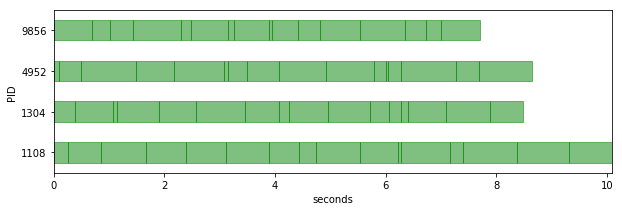

In [23]:
import matplotlib.pylab as plt
%matplotlib inline

delay_times = numpy.random.rand(64)
result = dummy_task.map(delay_times)
visualize_tasks(result)

In [24]:
result

[[1108, 1491315556.962189, 1491315557.228014],
 [1108, 1491315557.228014, 1491315557.8227797],
 [1108, 1491315557.8227797, 1491315558.6353607],
 [1108, 1491315558.6353607, 1491315559.3541873],
 [1108, 1491315559.3541873, 1491315560.073012],
 [1108, 1491315560.073012, 1491315560.8543477],
 [1108, 1491315560.8543477, 1491315561.401291],
 [1108, 1491315561.401291, 1491315561.6945083],
 [1108, 1491315561.6945083, 1491315562.4989045],
 [1108, 1491315562.4989045, 1491315563.1864746],
 [1108, 1491315563.1864746, 1491315563.233359],
 [1108, 1491315563.233359, 1491315564.124063],
 [1108, 1491315564.124063, 1491315564.358467],
 [1108, 1491315564.358467, 1491315565.3429604],
 [1108, 1491315565.3429604, 1491315566.2805483],
 [1108, 1491315566.2805483, 1491315567.0460985],
 [4952, 1491315556.962189, 1491315557.05612],
 [4952, 1491315557.05612, 1491315557.4640956],
 [4952, 1491315557.4640956, 1491315558.4478571],
 [4952, 1491315558.4478571, 1491315559.1354077],
 [4952, 1491315559.1354077, 1491315560

In [25]:
lbview = rc.load_balanced_view()

In [26]:
@lbview.parallel(block=True)
def dummy_task_load_balanced(delay):
    import os, time
    t0 = time.time()
    pid = os.getpid()
    time.sleep(delay)
    t1 = time.time()
    return [pid, t0, t1]

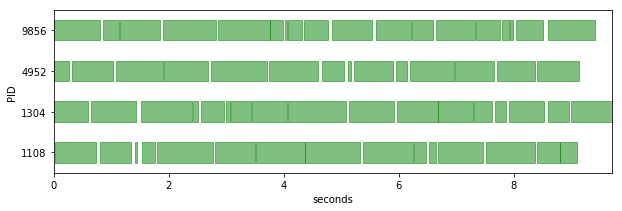

In [27]:
result = dummy_task_load_balanced.map(delay_times)
visualize_tasks(result)